## Creating main dataset to standardize for the Final Jupyter Notebook

Needs to have ROI, Budgets, and Runntime

In [6]:
### Import the nessesary libraries
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

In [7]:
df_num = pd.read_csv('tn.movie_budgets.csv')

In [8]:
conn = sqlite3.connect('im.db')
q = """
SELECT 
    primary_title AS p_title,
    runtime_minutes AS time_min,
    averagerating AS avg_rating,
    genres
FROM movie_basics
JOIN movie_ratings
    USING(movie_id)
;
"""
df_IMDB = pd.read_sql(q, conn)

Combine the two into a single dataframe

In [9]:
### Merge on Primary Title
df = pd.merge(df_IMDB, 
            df_num, 
            how='inner', 
            left_on = 'p_title', 
            right_on = 'movie')
#df.info()

Cleaning the dataset

In [10]:
#Domestic
df['domestic_millions'] = df.domestic_gross.str.replace(',','')
df['domestic_millions'] = df.domestic_millions.str.replace('$','')
df['domestic_millions'] = pd.to_numeric(df.domestic_millions) / 1000000

#Worldwide
df['worldwide_millions'] = df.worldwide_gross.str.replace(',','')
df['worldwide_millions'] = df.worldwide_millions.str.replace('$','')
df['worldwide_millions'] = pd.to_numeric(df.worldwide_millions) / 1000000

# Get rid of non-numerics in production_budget
df['budget_millions'] = df.production_budget.str.replace(',','')
df['budget_millions'] = df.budget_millions.str.replace('$','')
df['budget_millions'] = pd.to_numeric(df.budget_millions) / 1000000


#df.info()

C:\Users\deapillai\AppData\Local\Temp\ipykernel_40992\3464875893.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['domestic_millions'] = df.domestic_millions.str.replace('$','')
C:\Users\deapillai\AppData\Local\Temp\ipykernel_40992\3464875893.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['worldwide_millions'] = df.worldwide_millions.str.replace('$','')
C:\Users\deapillai\AppData\Local\Temp\ipykernel_40992\3464875893.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['budget_millions'] = df.budget_mill

In [11]:
#Drop duplicates
df.drop_duplicates(subset=['movie'], inplace=True)
# df.head(10)

In [12]:
#df.info()

Adding in the correct roi

In [13]:
df['roi'] = (df.worldwide_millions - df.budget_millions)/df.budget_millions

Add in the binning for the production budget

In [14]:
def binning(x):
    if x > 216:
        return 216
    elif x > 108:
        return 108
    elif x > 64:
        return 64
    elif x > 32:
        return 32
    elif x > 16:
        return 16
    elif x > 8:
        return 8
    elif x > 4:
        return 4
    elif x > 2:
        return 2
    else:
        return 1

In [15]:
x = [binning(x) for x in df['budget_millions']]

In [16]:
pd.options.mode.chained_assignment = None
df['budget_binning'] = x

In [17]:
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2874
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   p_title             2126 non-null   object 
 1   time_min            2072 non-null   float64
 2   avg_rating          2126 non-null   float64
 3   genres              2124 non-null   object 
 4   id                  2126 non-null   int64  
 5   release_date        2126 non-null   object 
 6   movie               2126 non-null   object 
 7   production_budget   2126 non-null   object 
 8   domestic_gross      2126 non-null   object 
 9   worldwide_gross     2126 non-null   object 
 10  domestic_millions   2126 non-null   float64
 11  worldwide_millions  2126 non-null   float64
 12  budget_millions     2126 non-null   float64
 13  roi                 2126 non-null   float64
 14  budget_binning      2126 non-null   int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 265.8+

# Genre Z-Test Analysis

In [18]:
df = df.dropna()
myList = df['genres'].tolist()
genre_list=[]
for i in range(len(myList)):
    genre_list.append(myList[i].split(','))
#genre_list

In [19]:
from itertools import chain
genres=list(set(chain(*genre_list)))
#print(genres)
#print(len(genres))
#print(type(genres))

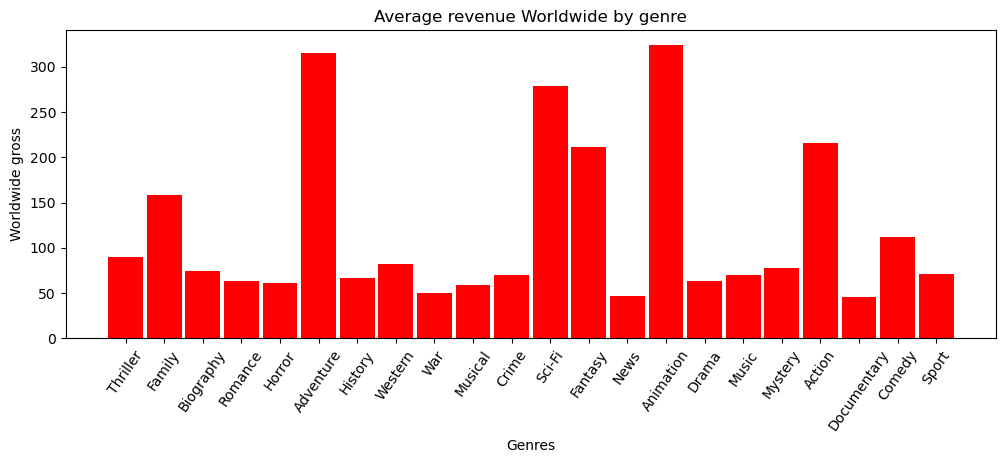

In [20]:
#Worldwide gross Average profits.
wwg_avg=[] 
for i in range(len(genres)):
    wwg = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    wwg_avg.append(df['worldwide_millions'][wwg].mean())
    
fig = plt.figure(figsize = (12, 4))
 
# creating the bar plot
plt.bar(genres, wwg_avg, color = 'red',width = 0.9)
 
plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("Worldwide gross")
plt.title("Average revenue Worldwide by genre")
plt.show()

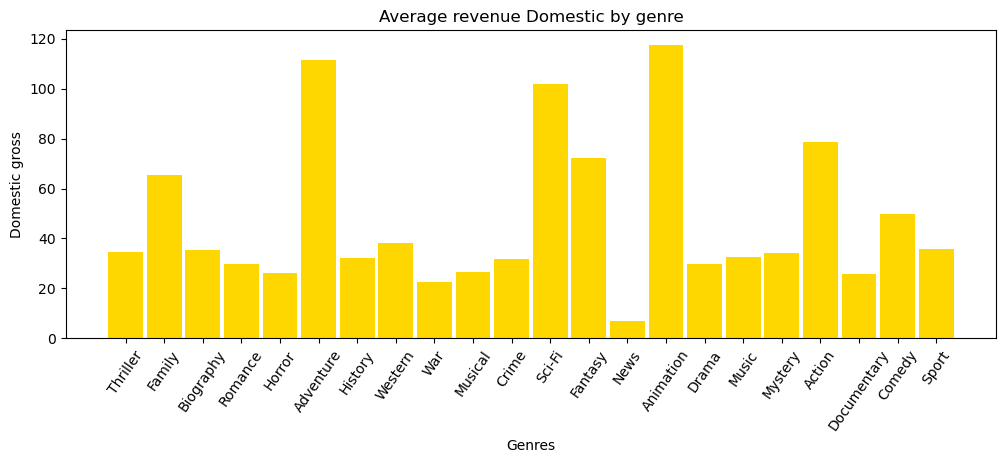

In [21]:
#Domestic gross Average profits.
dg_avg=[]
for i in range(len(genres)):
    dg = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    dg_avg.append(df['domestic_millions'][dg].mean())
#dg_avg

fig = plt.figure(figsize = (12, 4))
plt.bar(genres, dg_avg, color='gold' ,width = 0.9)
 
plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("Domestic gross")
plt.title("Average revenue Domestic by genre")
plt.show()

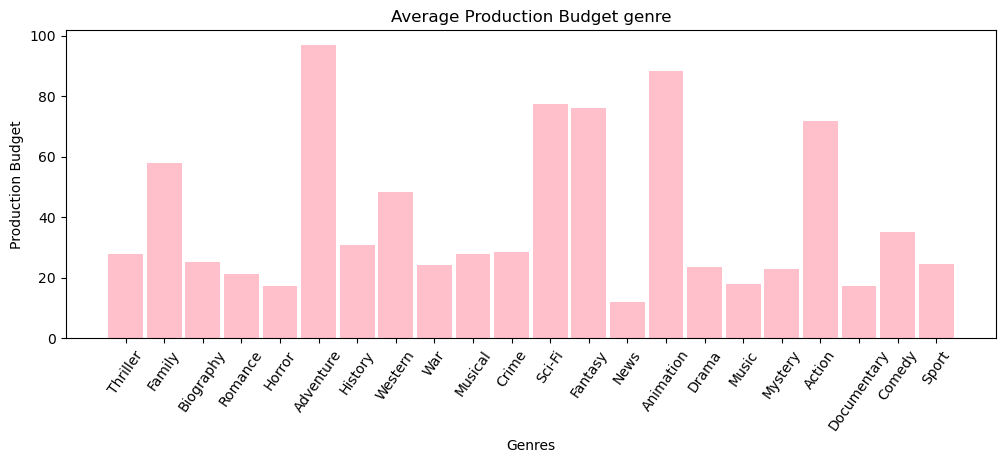

In [22]:
#production_budget Average profits.
pb_avg=[]
for i in range(len(genres)):
    pb = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    pb_avg.append(df['budget_millions'][pb].mean())
#print(pb_avg)


fig = plt.figure(figsize = (12, 4))
plt.bar(genres, pb_avg, color='pink' ,width = 0.9)
 
plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("Production Budget")
plt.title("Average Production Budget genre")
plt.show()

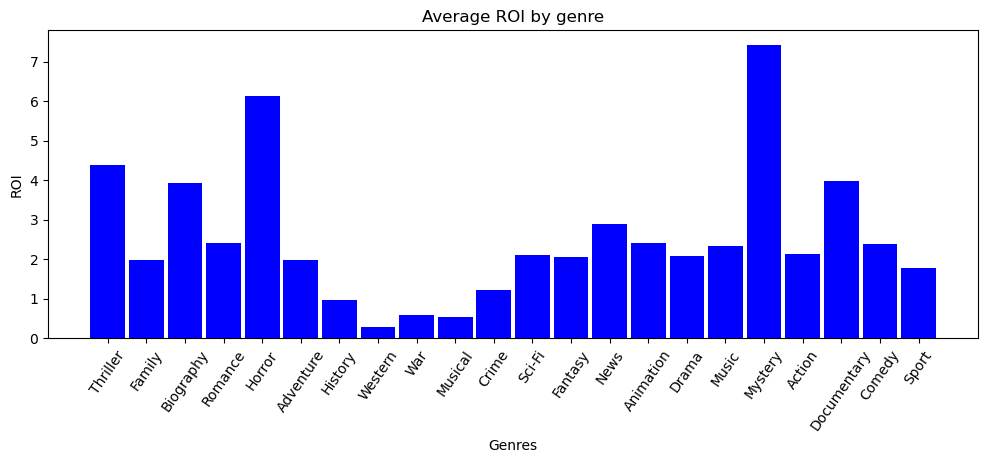

In [23]:
#Roi Average profits.
roi_avg=[]
for i in range(len(genres)):
    roi = df['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    roi_avg.append(df['roi'][roi].mean())
#print(roi_avg)


fig = plt.figure(figsize = (12, 4))
plt.bar(genres, roi_avg, color='blue' ,width = 0.9)

plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("ROI")
plt.title("Average ROI by genre")
plt.show()

## Hypothesis Testing

Our team wanted to see if Mystery, Horror and Thriller movies generete a larger ROI than other genres.

### State our Hypotheses:
H-Alt -> The average ROI for Mystery, Horror and Thriller is higher than other movies  $$\large H_a\text{:   }\mu < \bar{x}$$

H-Null -> There is no difference in the ROI for Mystery, , Horror and Thriller vs. other movies  $$\large H_o\text{:   }\mu \geq \bar{x}$$

Alpha: 0.05

In [24]:
df.describe()

,time_min,avg_rating,id,domestic_millions,worldwide_millions,budget_millions,roi,budget_binning
count,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.000000,2070.00000
mean,103.908213,6.228068,50.533333,46.721206,114.225849,37.497390,2.654110,27.05942
std,18.747006,1.130268,28.547208,78.051190,216.068937,51.466797,13.790324,37.08651
min,5.000000,1.600000,1.000000,0.000000,0.000000,0.001400,-1.000000,1.00000
25%,91.000000,5.600000,26.000000,0.641150,2.507165,5.000000,-0.625003,4.00000
50%,102.000000,6.300000,50.000000,18.964095,33.204586,19.000000,0.696789,16.00000
75%,114.000000,7.000000,75.000000,56.449204,116.736437,45.000000,2.644018,32.00000
max,180.000000,9.200000,100.000000,760.507625,2776.345279,425.000000,415.564740,216.00000


In [25]:
#population mean and std

roi_mean = df['roi'].mean()
roi_std = df['roi'].std()

stats.norm(roi_mean, roi_std)
plt.style.use('seaborn')

In [26]:
#Mystery mean
df_mystery = df[df['genres'].str.contains('Mystery')]
mystery_mean = df_mystery['roi'].mean()
#df_mystery
#print(mystery_mean)

#Horror mean
df_horror = df[df['genres'].str.contains('Horror')]
horror_mean = df_horror['roi'].mean()
#df_mystery
#print(mystery_mean)

#Thriller mean
df_thriller = df[df['genres'].str.contains('Thriller')]
thriller_mean = df_thriller['roi'].mean()
#df_mystery
#print(mystery_mean)

#Biography mean
df_Biography = df[df['genres'].str.contains('Biography')]
Biography_mean = df_Biography['roi'].mean()
#df_mystery
#print(mystery_mean)

In [27]:
# Z score Function
from math import sqrt
def Zscore(Dataframe, mean):
    x_bar= mean
    n =  len(Dataframe.id)
    sigma = roi_std
    mu = roi_mean
    z = (x_bar - mu)/(sigma/sqrt(n))

    pval= 1-stats.norm.cdf(z)
    print(f'P-value: {pval}') 
    print(pval<0.05)
    print(f'Percent area under the curve from Zscore of {z} is {stats.norm.cdf(z)*100}% \n')
   
    
Zscore(df_mystery, mystery_mean)
Zscore(df_horror, horror_mean)
Zscore(df_thriller, thriller_mean)
Zscore(df_Biography, Biography_mean)

P-value: 4.619940964678548e-06
True
Percent area under the curve from Zscore of 4.434237277030216 is 99.99953800590353% 

P-value: 2.0679048268856803e-05
True
Percent area under the curve from Zscore of 4.0997587910955895 is 99.99793209517311% 

P-value: 0.00875883944924516
True
Percent area under the curve from Zscore of 2.3756582508011994 is 99.12411605507549% 

P-value: 0.11578012490354661
False
Percent area under the curve from Zscore of 1.1963493710680468 is 88.42198750964533% 



# Law of Diminishing Returns Analysis

The objective with this analysis is to visualize the law of dimishing returns comparing production budget (our group will assume that production budget is cost) to the overall rating and ROI of the film.

Starting with Production budget vs. Overall Rating

<AxesSubplot:xlabel='avg_rating', ylabel='budget_millions'>

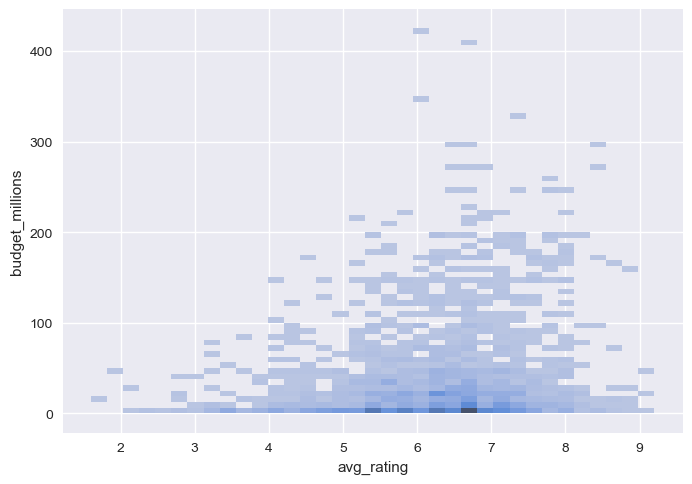

In [28]:
#First a simple viuslization
sns.histplot(x=df.avg_rating,
             y=df.budget_millions)

From this visual we can see that the average ratings are concentrated around the mean, as well as there are many outliers in budget upward of 200 Million. Using the binning already added into the dataframe, we can bin the production budgets for a visualization showing the increase in budget vs the average rating. This will demonstrate the rate and variance of ratings as production budget (Movie Costs) increase.

C:\Users\deapillai\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'Budget Millions'),
 Text(0, 0.5, 'Average Rating'),
 Text(0.5, 1.0, 'Diminishing Ratings as Budget Increases')]

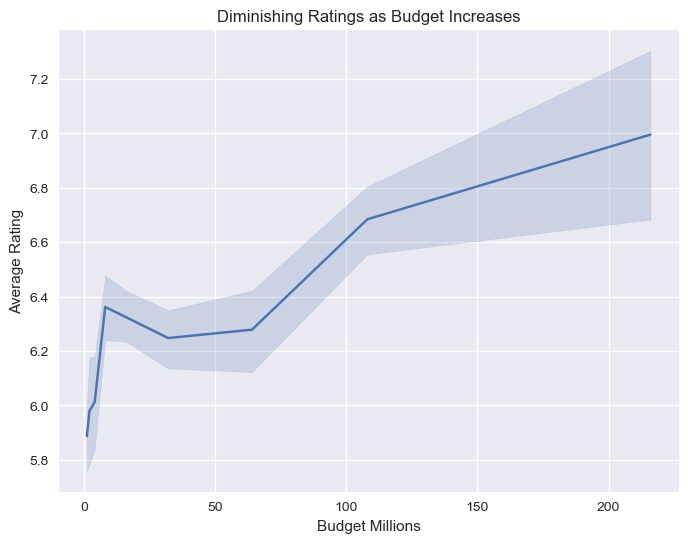

In [29]:
# Use matplotlib to set the figure size and shape
fig, ax = plt.subplots(figsize=(8,6))

#Create a lineplot of both using seaborn
ax = sns.lineplot(df.budget_binning, df.avg_rating)
ax.set(xlabel='Budget Millions', ylabel='Average Rating', title='Diminishing Ratings as Budget Increases')
# ax.axhline(df.avg_rating.mean(), color='red')

Based on the plot above, we can see that after budgets start to excede 100 million, returns start to diminish as well as become more volitile. It shows that ratings will tend to show less improvement in ratings as the production budget increases. Now let's try the same thing but for ROI.

C:\Users\deapillai\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


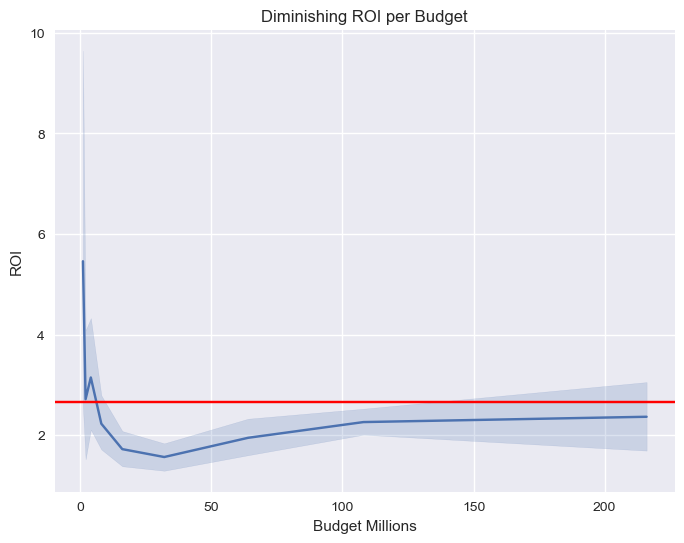

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(df.budget_binning, df.roi)
ax.set(xlabel='Budget Millions', ylabel='ROI', title='Diminishing ROI per Budget')
ax.axhline(df.roi.mean(), color='red')

Based on the graph above, there seem to be a large amount of outliers on the upper end of ROI skewing our data. To get rid of that we're going to make a normal distribution using the ROI data points, and keep the lower 99% of those values as to not deal with large and unlikely ROI's.

In [31]:
dist = stats.norm(df.roi.mean(),df.roi.std())
dist.ppf(.99)
#This now identifies the new cutoff for ROI values. 
#We can use this to drop rows with ROI's greater than that

34.735199956818

In [32]:
#Drop ROI's where the roi is > 3
df_dropped34 = df.drop(df[df['roi'] > 34].index, inplace=False)
df_dropped34.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2053 entries, 0 to 2873
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   p_title             2053 non-null   object 
 1   time_min            2053 non-null   float64
 2   avg_rating          2053 non-null   float64
 3   genres              2053 non-null   object 
 4   id                  2053 non-null   int64  
 5   release_date        2053 non-null   object 
 6   movie               2053 non-null   object 
 7   production_budget   2053 non-null   object 
 8   domestic_gross      2053 non-null   object 
 9   worldwide_gross     2053 non-null   object 
 10  domestic_millions   2053 non-null   float64
 11  worldwide_millions  2053 non-null   float64
 12  budget_millions     2053 non-null   float64
 13  roi                 2053 non-null   float64
 14  budget_binning      2053 non-null   int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 256.6+

Let's run the graph again, this time without the large outliers on ROI.

C:\Users\deapillai\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


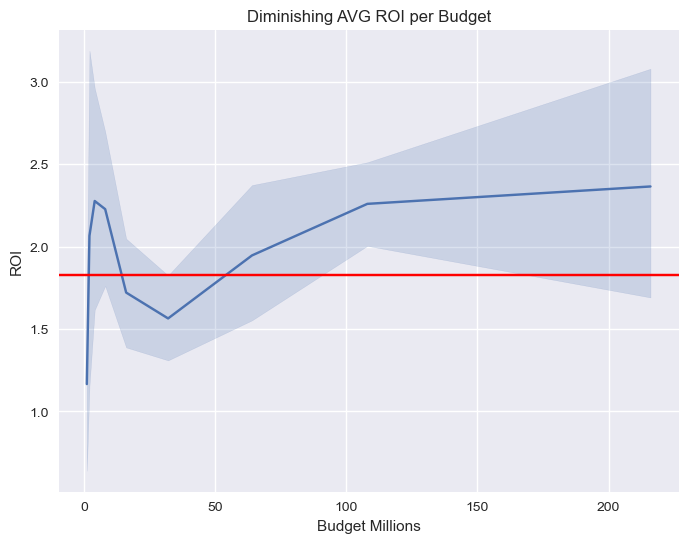

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(df_dropped34.budget_binning, df_dropped34.roi)
ax.set(xlabel='Budget Millions', ylabel='ROI', title='Diminishing AVG ROI per Budget')
ax.axhline(df_dropped34.roi.mean(), color='red')

From the graph above, we can now see that returns on investment virtually flatline after 100 million in production budget, with an increase in volatility. From both average ROI and average rating, we can say that returns diminish substantially after an investment of 100 million.

# Rating to Worldwide Revenue Assessment

This is the first draft of a scatter plot comparing the average ratings to the worldwide gross margin of each movie

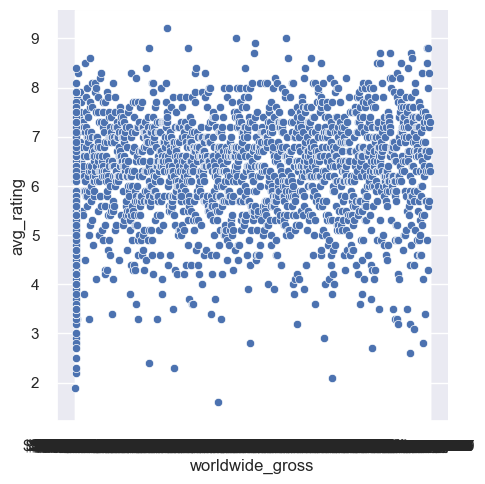

In [34]:
## First Draft
sns.set_theme()
sns.relplot(
            y=df.avg_rating, 
            x=df.worldwide_gross
            )

We needed to determine the line of best fit for the data and plot it accordingly

C:\Users\deapillai\AppData\Local\Temp\ipykernel_40992\3836098876.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['worldwide_gross_numeric'] = pd.to_numeric(df['worldwide_gross'].str.replace(',', '').str.replace('$', ''))


<AxesSubplot:xlabel='worldwide_gross_numeric', ylabel='avg_rating'>

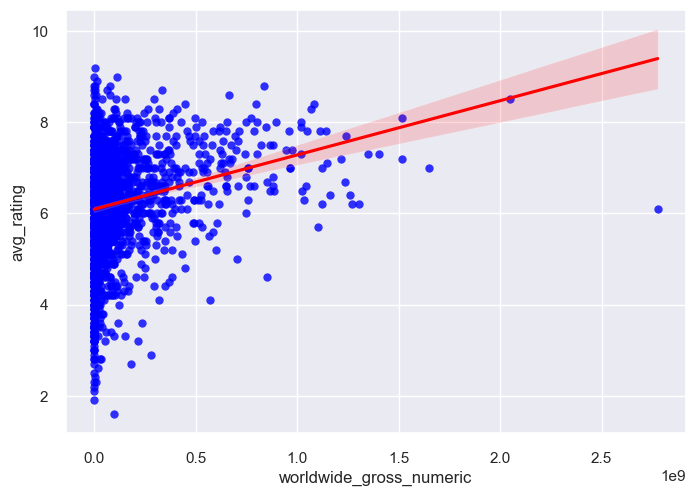

In [35]:
## Regression Data
df['worldwide_gross_numeric'] = pd.to_numeric(df['worldwide_gross'].str.replace(',', '').str.replace('$', ''))
sns.regplot(
    y=df['avg_rating'],
    x=df['worldwide_gross_numeric'],
    scatter_kws={"color": "blue"},
    line_kws={"color": "red"}
)


In order to remain consistent we need to flip the axes 

C:\Users\deapillai\AppData\Local\Temp\ipykernel_40992\3117557407.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['worldwide_gross_numeric'] = pd.to_numeric(df['worldwide_gross'].str.replace(',', '').str.replace('$', ''))


<AxesSubplot:xlabel='avg_rating', ylabel='worldwide_gross_numeric'>

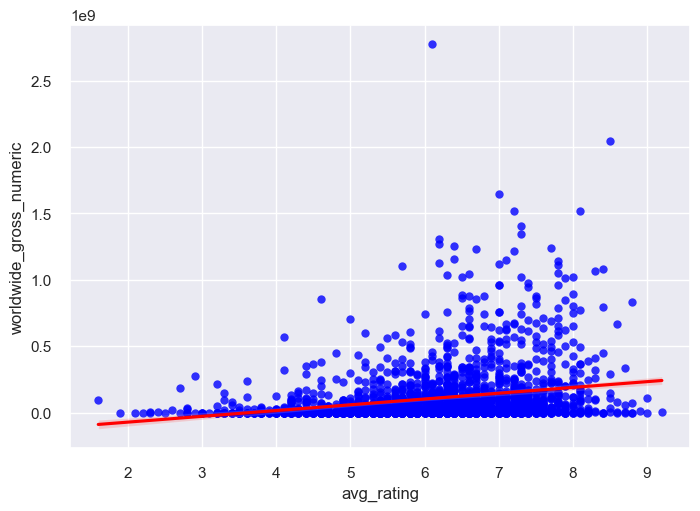

In [36]:
## Regression Data
df['worldwide_gross_numeric'] = pd.to_numeric(df['worldwide_gross'].str.replace(',', '').str.replace('$', ''))
sns.regplot(
    y=df['worldwide_gross_numeric'],
    x=df['avg_rating'],
    scatter_kws={"color": "blue"},
    line_kws={"color": "red"},
)

In conclusion, Ratings are valuable and Computing Vision should target above a 6 rating to ensure the best possible results. We can also clearly see there are diminishing returns after about a 7.75-8 rating where there are less positive outliers. This shows that it is extremely valuable to reach a certain movie standard but not worth crazy investments of time and money to get above an 8.

# Ideal Runtime

In [38]:
df_rating = df.drop(df[df['avg_rating'] < 7.1].index, inplace=False)
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 6 to 2872
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   p_title                  495 non-null    object 
 1   time_min                 495 non-null    float64
 2   avg_rating               495 non-null    float64
 3   genres                   495 non-null    object 
 4   id                       495 non-null    int64  
 5   release_date             495 non-null    object 
 6   movie                    495 non-null    object 
 7   production_budget        495 non-null    object 
 8   domestic_gross           495 non-null    object 
 9   worldwide_gross          495 non-null    object 
 10  domestic_millions        495 non-null    float64
 11  worldwide_millions       495 non-null    float64
 12  budget_millions          495 non-null    float64
 13  roi                      495 non-null    float64
 14  budget_binning           

Created a new dataframe that drops all the movies with a rating less than 7.1.

In [40]:
df_rating.describe()

,time_min,avg_rating,id,domestic_millions,worldwide_millions,budget_millions,roi,budget_binning,worldwide_gross_numeric
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,4.950000e+02
mean,110.561616,7.555354,48.286869,74.773959,183.835109,46.209548,3.159705,32.797980,1.838351e+08
std,23.784281,0.419715,28.145345,108.916138,287.902745,60.142468,5.062989,43.408142,2.879027e+08
min,5.000000,7.100000,1.000000,0.000000,0.000000,0.015000,-1.000000,1.000000,0.000000e+00
25%,96.000000,7.200000,25.000000,4.500733,11.789684,8.000000,0.175280,4.000000,1.178968e+07
50%,109.000000,7.400000,46.000000,33.395426,64.282881,20.000000,1.789445,16.000000,6.428288e+07
75%,126.500000,7.800000,72.000000,99.710649,211.717843,55.000000,4.136459,32.000000,2.117178e+08
max,180.000000,9.200000,100.000000,700.059566,2048.134200,330.600000,50.073590,216.000000,2.048134e+09


Describing the new data frame created. 

[Text(0.5, 0, 'Runtime in Minutes'),
 Text(0, 0.5, ' Count of Movies Above Average Rating'),
 Text(0.5, 1.0, 'Movie Rating to Movie Runtime')]

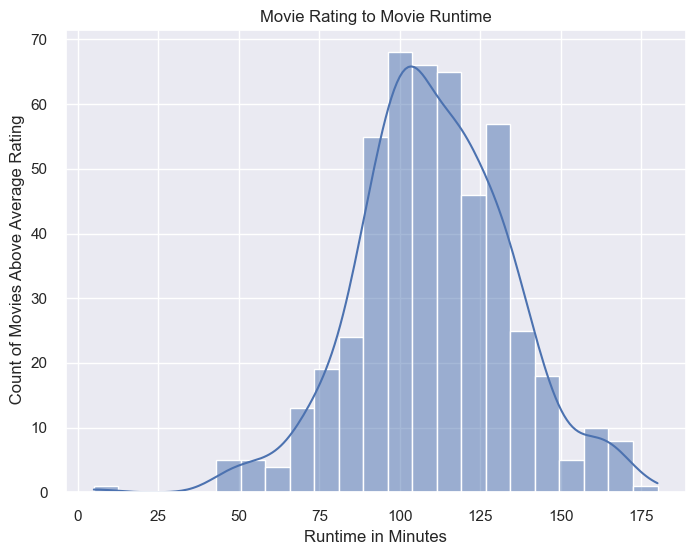

In [45]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.histplot(df_rating.time_min, kde = True)
ax.set(xlabel='Runtime in Minutes', ylabel=' Count of Movies Above Average Rating', title='Movie Rating to Movie Runtime')


Created a graph showing that movies between 80 and 125 minutes are optimal for an above average rating.